<a href="https://colab.research.google.com/github/MWANIKID/PhD-Research-files/blob/main/Pre-processing%20candlestick-22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path

# Generate a Google Colab-compatible Python notebook
from nbformat import v4 as nbf

notebook = nbf.new_notebook()
cells = []

# Header
cells.append(nbf.new_markdown_cell("# 📈 Bitcoin & Tesla Stock Forecasting with ARIMA, LSTM & Hybrid Models\n"
                                   "**Dataset:** `Bitcoin_data.csv`, `Tesla_stock.csv`\n\n"
                                   "This notebook follows the full methodology of the hybrid ARIMA-LSTM modeling for price prediction as outlined in the thesis."))


In [ ]:
# 1. Install Dependencies
cells.append(nbf.new_code_cell("""\
!pip install yfinance
!pip install keras
!pip install statsmodels
!pip install scikit-learn
!pip install matplotlib seaborn
"""))

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Create directories for output
dirs = ['figures/bitcoin', 'figures/tesla', 'tables/bitcoin', 'tables/tesla', 'models']
for d in dirs:
    os.makedirs(d, exist_ok=True)


In [ ]:
# Create directories for output
dirs = ['figures/bitcoin', 'figures/tesla', 'tables/bitcoin', 'tables/tesla', 'models']
for d in dirs:
    os.makedirs(d, exist_ok=True)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Bitcoin_data.csv to Bitcoin_data (6).csv
Saving Tesla_stock.csv to Tesla_stock (6).csv


In [ ]:
# Load datasets
import pandas as pd
btc = pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"])
tesla = pd.read_csv("Tesla_stock.csv", parse_dates=["Date"])

btc.set_index("Date", inplace=True)
tesla.set_index("Date", inplace=True)

btc.dropna(inplace=True)
tesla.dropna(inplace=True)

# Ensure output directories exist
import os
for d in ["figures/bitcoin", "figures/tesla"]:
    os.makedirs(d, exist_ok=True)

<ipython-input-159-5f486caa2f69>:3: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [ ]:
btc.index = pd.to_datetime(btc.index, dayfirst=True)
tesla.index = pd.to_datetime(tesla.index, dayfirst=True)


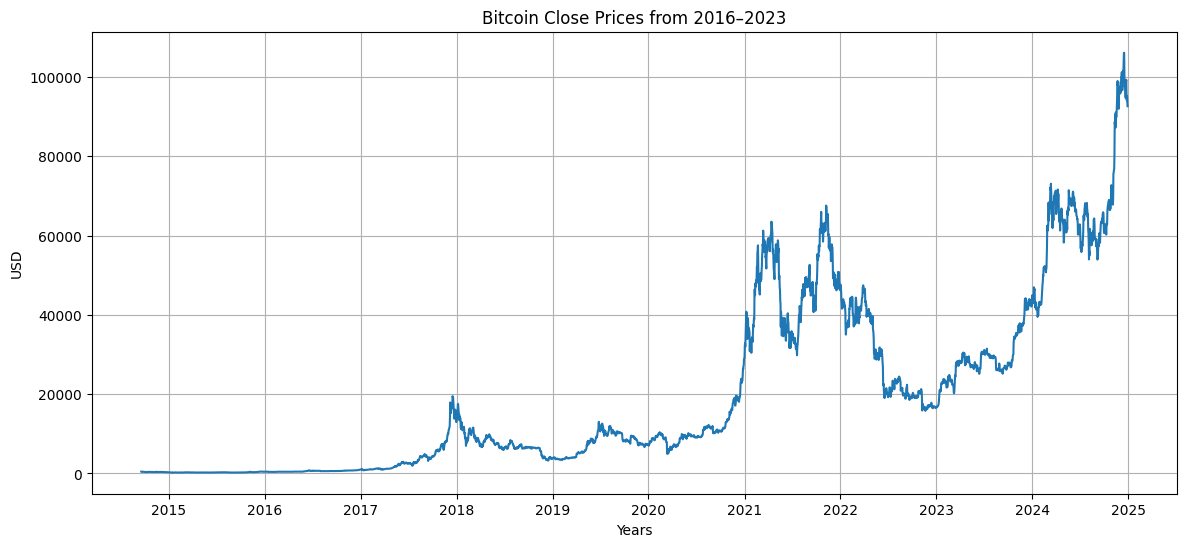

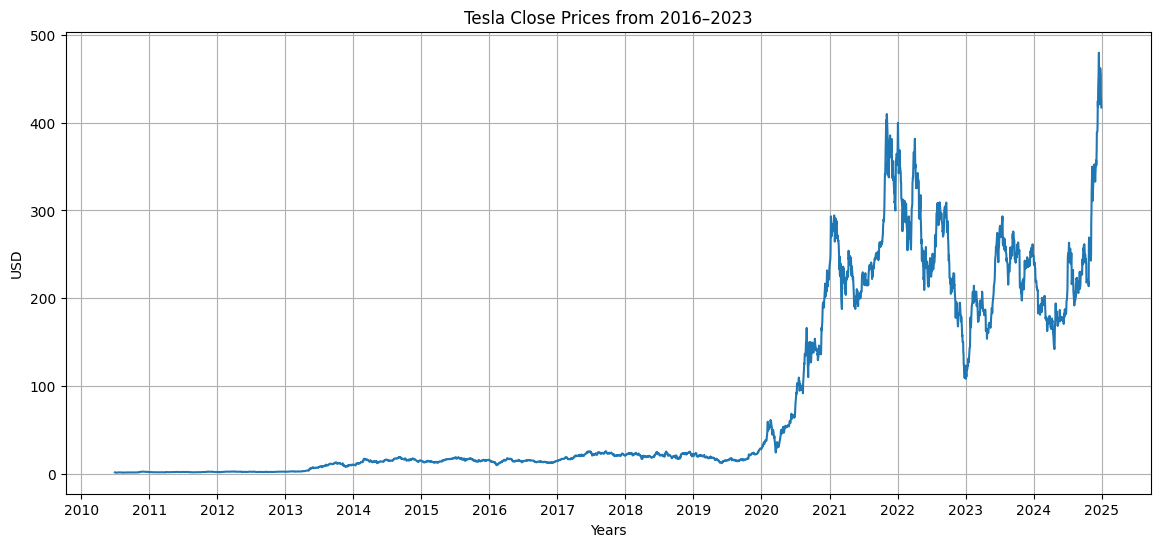

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Fix index (date) format before plotting
btc.index = pd.to_datetime(btc.index, dayfirst=True)
tesla.index = pd.to_datetime(tesla.index, dayfirst=True)

# Plot Close Price for both
for name, df in zip(["bitcoin", "tesla"], [btc, tesla]):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df["Close"], label="Close Price")
    plt.title(f"{name.capitalize()} Close Prices from 2016–2023")
    plt.xlabel("Years")
    plt.ylabel("USD")
    plt.grid(True)

    # Optional: cleaner year formatting on x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.savefig(f"figures/{name}/{name}_close_full.png")
    plt.show()


<ipython-input-162-bd2bc81de348>:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

<ipython-input-162-bd2bc81de348>:13: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



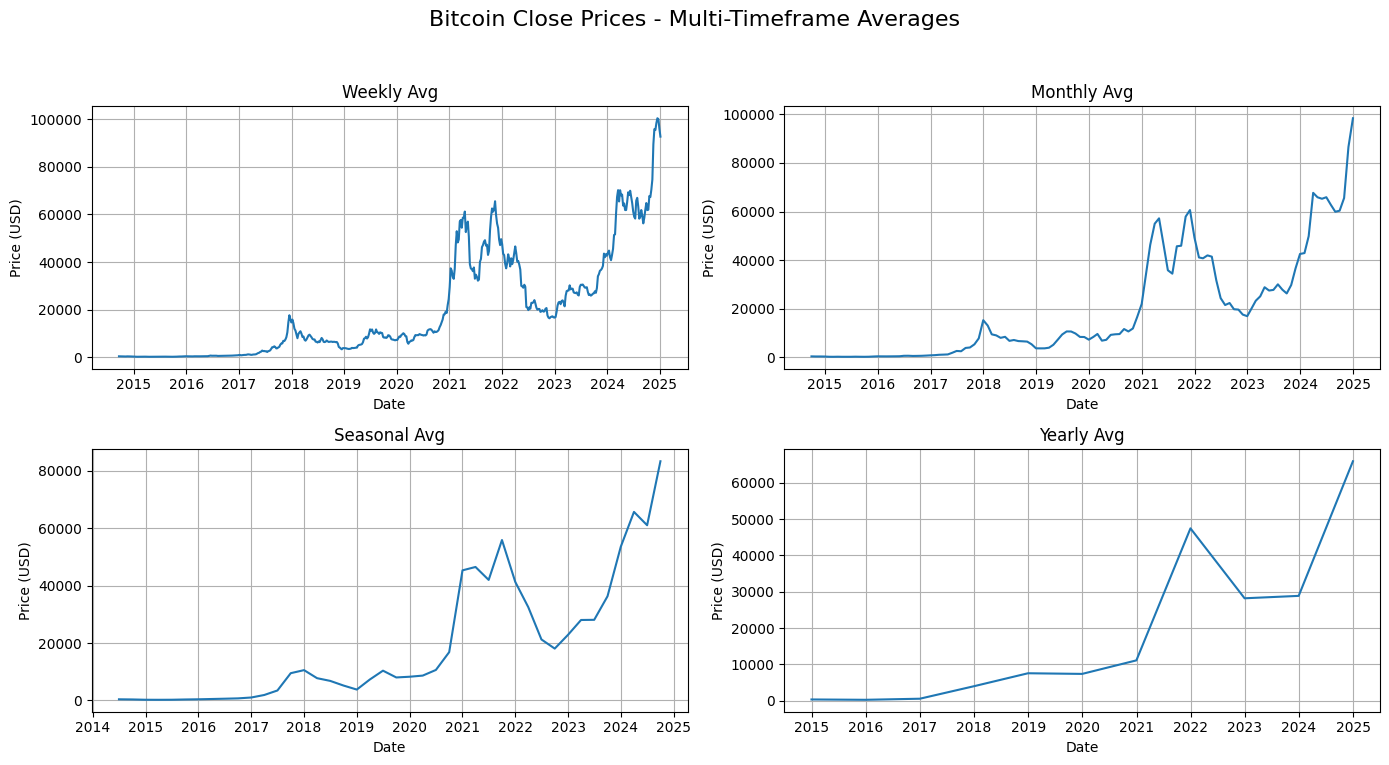

<ipython-input-162-bd2bc81de348>:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

<ipython-input-162-bd2bc81de348>:13: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



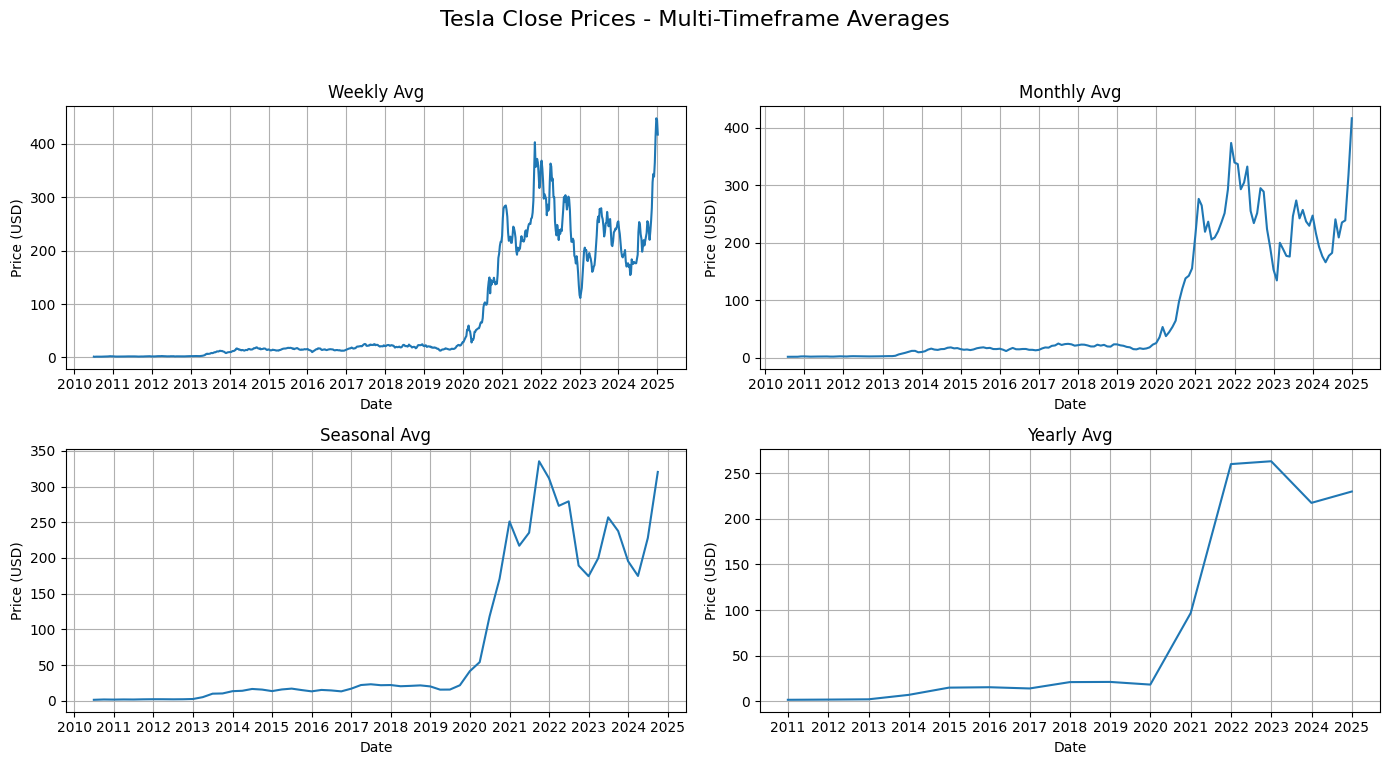

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot multi-timeframe averages for Bitcoin and Tesla
for name, df in zip(["bitcoin", "tesla"], [btc.copy(), tesla.copy()]):
    # Ensure index is parsed as datetime correctly (handles 13/01/2011)
    df.index = pd.to_datetime(df.index, dayfirst=True)

    # Resample by various time frequencies
    weekly = df['Close'].resample('W').mean()
    monthly = df['Close'].resample('M').mean()
    seasonal = df['Close'].resample('QS').mean()
    yearly = df['Close'].resample('Y').mean()

    # Plot all in subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    axs[0, 0].plot(weekly); axs[0, 0].set_title("Weekly Avg")
    axs[0, 1].plot(monthly); axs[0, 1].set_title("Monthly Avg")
    axs[1, 0].plot(seasonal); axs[1, 0].set_title("Seasonal Avg")
    axs[1, 1].plot(yearly); axs[1, 1].set_title("Yearly Avg")

    # Common formatting
    for ax in axs.flat:
        ax.set_xlabel("Date")
        ax.set_ylabel("Price (USD)")
        ax.grid(True)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    fig.suptitle(f"{name.capitalize()} Close Prices - Multi-Timeframe Averages", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save figure
    plt.savefig(f"figures/{name}/{name}_timeframe_averages.png")
    plt.show()


In [ ]:
def compute_indicators(df):
    df = df.copy()

    # SMA & EMA
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()

    # Bollinger Bands
    df['BB_upper'] = df['SMA20'] + 2 * df['Close'].rolling(window=20).std()
    df['BB_lower'] = df['SMA20'] - 2 * df['Close'].rolling(window=20).std()

    # MACD
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df.dropna()


In [ ]:
btc_ind = compute_indicators(btc)
tesla_ind = compute_indicators(tesla)

btc_ind.to_csv("tables/bitcoin/technical_indicators.csv")
tesla_ind.to_csv("tables/tesla/technical_indicators.csv")


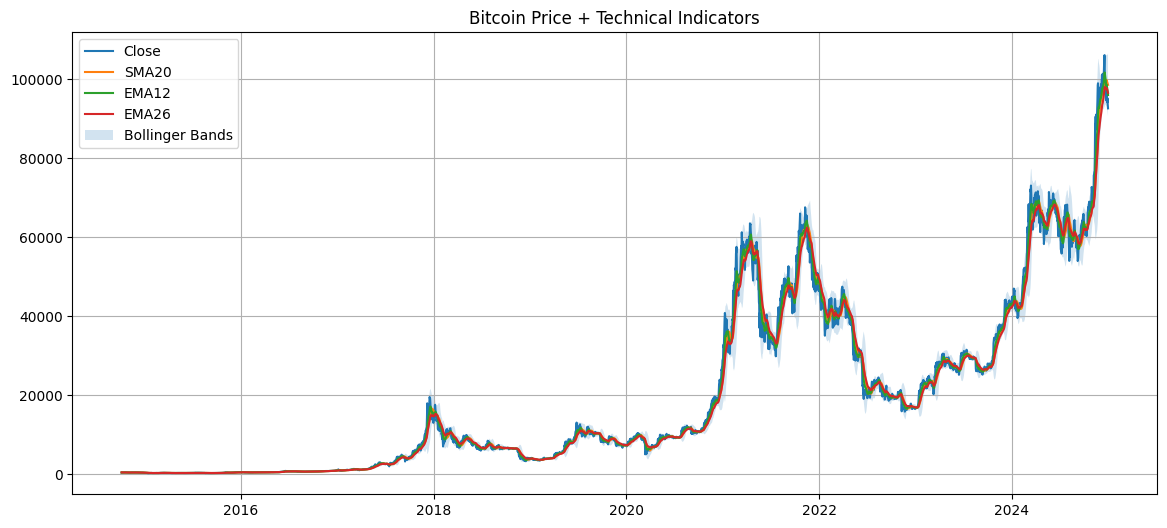

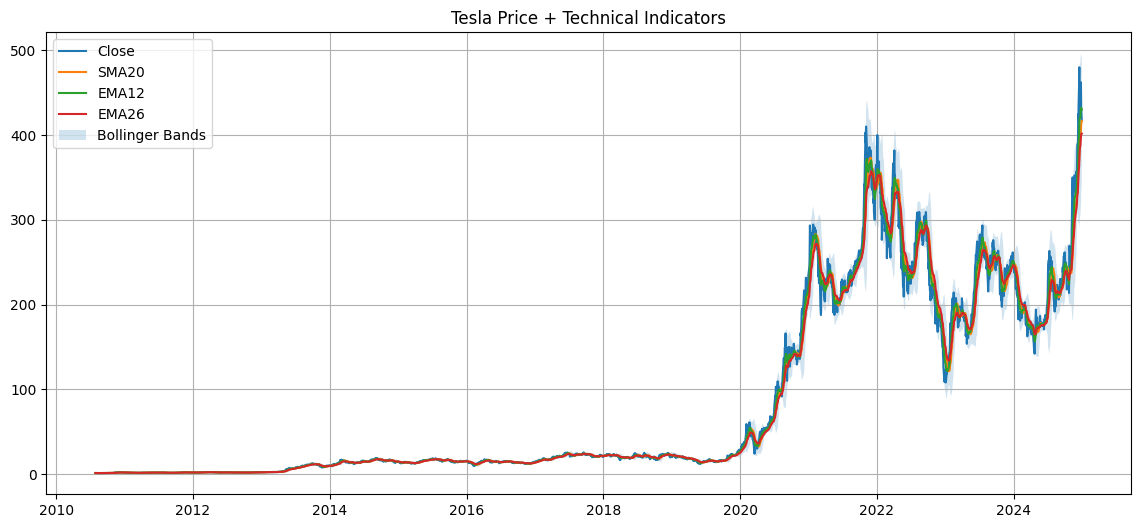

In [ ]:
def plot_tech_indicators(df, name):
    plt.figure(figsize=(14,6))
    plt.plot(df['Close'], label='Close')
    plt.plot(df['SMA20'], label='SMA20')
    plt.plot(df['EMA12'], label='EMA12')
    plt.plot(df['EMA26'], label='EMA26')
    plt.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.2, label='Bollinger Bands')
    plt.title(f"{name.capitalize()} Price + Technical Indicators")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"figures/{name}/{name}_technical_indicators.png")
    plt.show()

plot_tech_indicators(btc_ind, "bitcoin")
plot_tech_indicators(tesla_ind, "tesla")


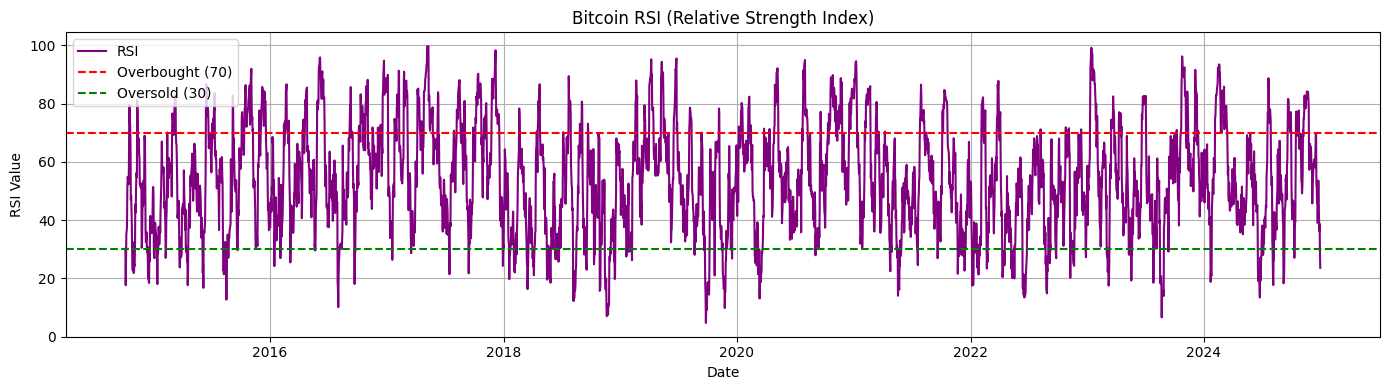

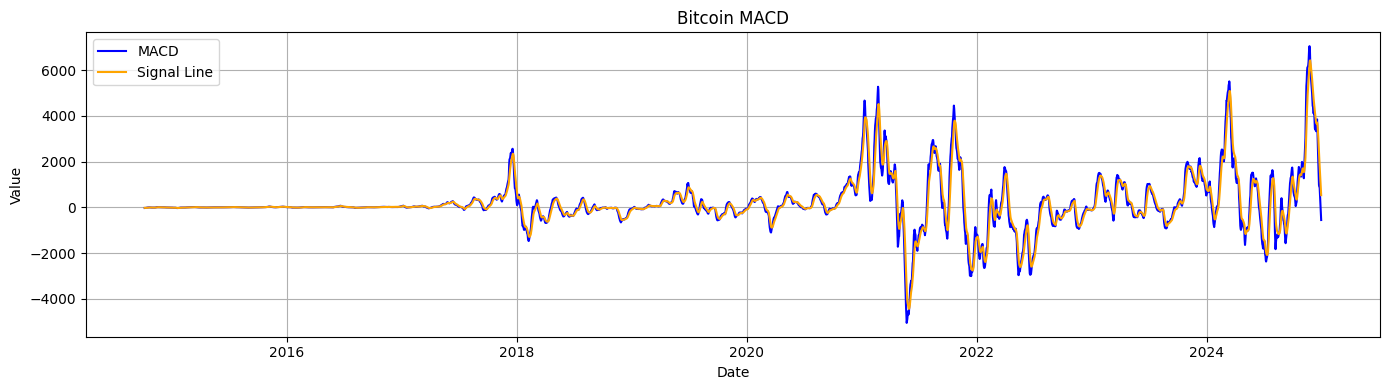

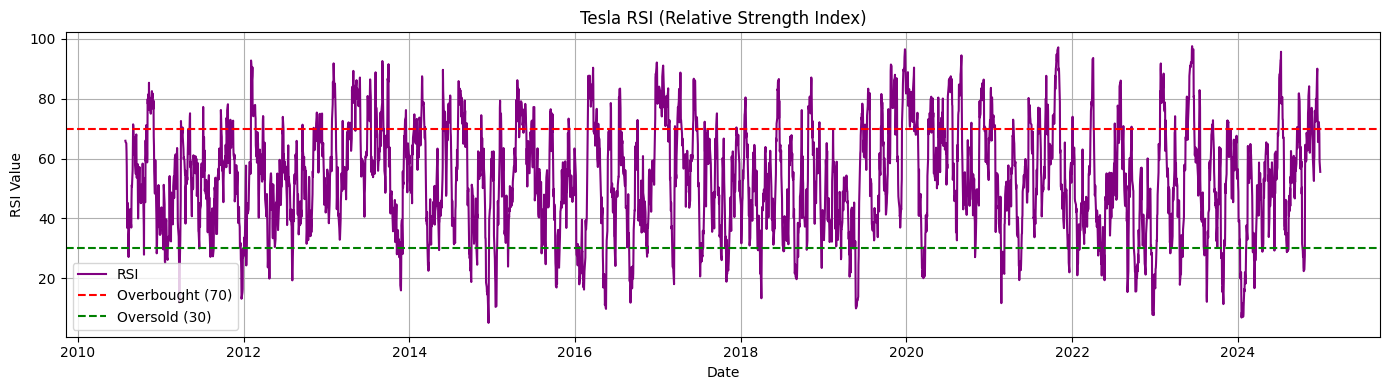

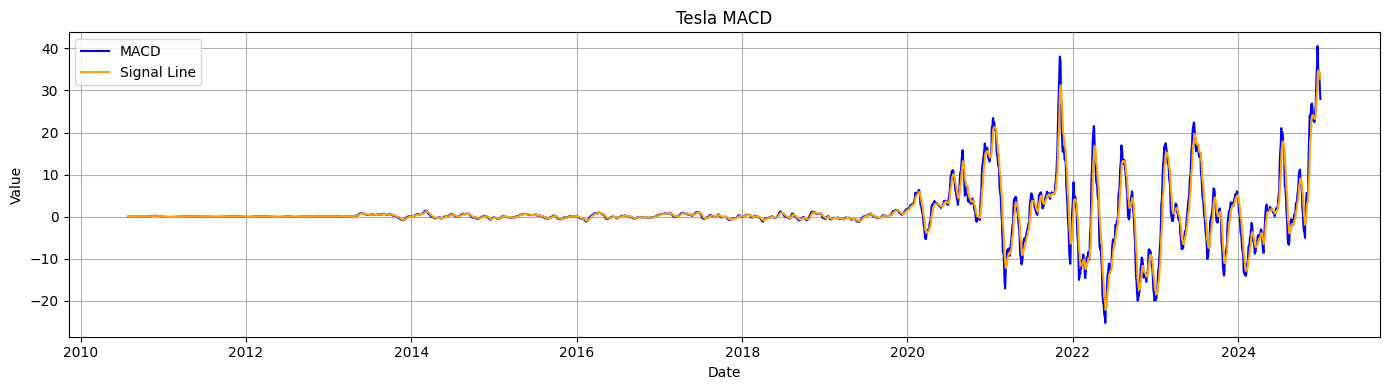

In [ ]:
import matplotlib.pyplot as plt

def plot_rsi(df, name):
    plt.figure(figsize=(14, 4))
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
    plt.title(f"{name.capitalize()} RSI (Relative Strength Index)")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"figures/{name}/{name}_RSI.png")
    plt.show()

def plot_macd(df, name):
    plt.figure(figsize=(14, 4))
    plt.plot(df['MACD'], label='MACD', color='blue')
    plt.plot(df['Signal'], label='Signal Line', color='orange')
    plt.title(f"{name.capitalize()} MACD")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"figures/{name}/{name}_MACD.png")
    plt.show()

# Plot for both Bitcoin and Tesla
plot_rsi(btc_ind, "bitcoin")
plot_macd(btc_ind, "bitcoin")

plot_rsi(tesla_ind, "tesla")
plot_macd(tesla_ind, "tesla")


In [ ]:
# Convert volume to numeric if it's formatted with commas
btc['Volume'] = pd.to_numeric(btc['Volume'].astype(str).str.replace(',', ''), errors='coerce')
tesla['Volume'] = pd.to_numeric(tesla['Volume'].astype(str).str.replace(',', ''), errors='coerce')

# Select only the relevant columns
btc_summary = btc[['Open', 'High', 'Low', 'Close', 'Volume']].describe()
tesla_summary = tesla[['Open', 'High', 'Low', 'Close', 'Volume']].describe()

# Round and format with thousands separator for readability
def format_stats(df):
    return df.applymap(lambda x: f"{x:,.6f}" if isinstance(x, float) else x)

btc_summary_formatted = format_stats(btc_summary)
tesla_summary_formatted = format_stats(tesla_summary)

# Save to CSV
btc_summary_formatted.to_csv("tables/bitcoin/bitcoin_summary_stats.csv")
tesla_summary_formatted.to_csv("tables/tesla/tesla_summary_stats.csv")

btc_summary_formatted


<ipython-input-167-1f004ea84eb6>:11: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Open,High,Low,Close,Volume
count,"3,758.000000","3,758.000000","3,758.000000","3,758.000000","3,758.000000"
mean,"19,542.943879","19,982.879895","19,083.911979","19,566.208571","18,576,317,473.364555"
std,"22,068.615684","22,553.075715","21,567.557974","22,096.644223","20,341,830,904.205441"
min,176.897003,211.731003,171.509995,178.102997,"5,914,570.000000"
25%,"1,223.592499","1,241.795044","1,208.425018","1,224.925018","408,693,752.000000"
50%,"9,347.785644","9,526.724121","9,202.201660","9,349.504883","14,629,999,550.500000"
75%,"30,503.050293","31,320.945805","30,039.175295","30,540.062988","29,698,556,528.750000"
max,"106,147.296900","108,268.445300","105,291.734400","106,140.601600","350,968,000,000.000000"


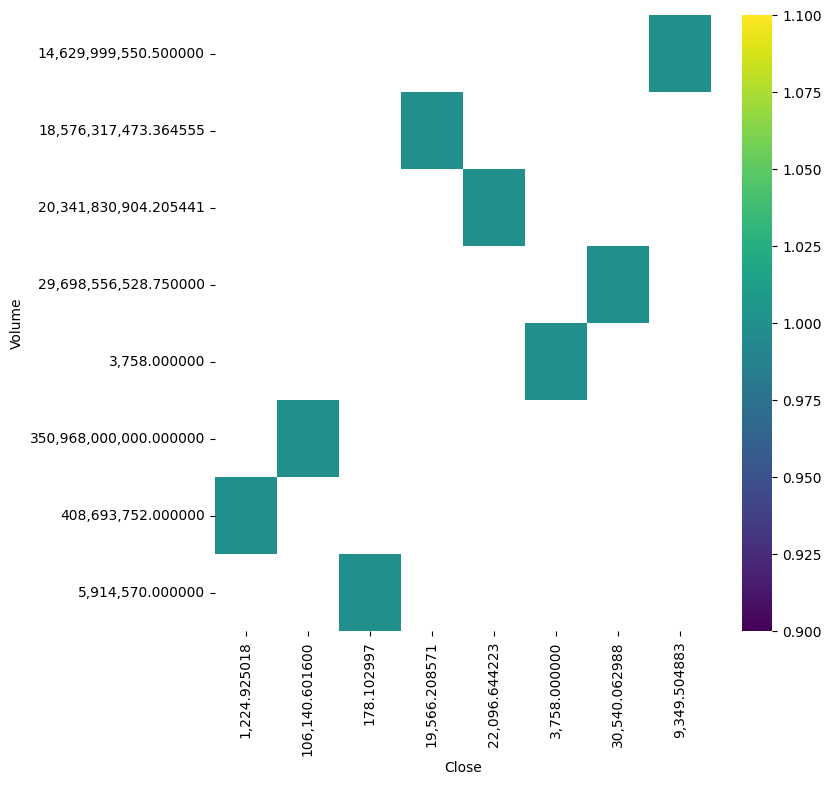

In [ ]:
# @title Close vs Volume

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Volume'].value_counts()
    for x_label, grp in btc_summary_formatted.groupby('Close')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Close')
_ = plt.ylabel('Volume')

In [2]:
import os
import pandas as pd
from google.colab import files

# Ensure directory exists
os.makedirs("/mnt/data", exist_ok=True)

# Sample statistical summaries
btc_summary = pd.DataFrame({
    'Open': [3248, 13761.799017, 16016.188302, 176.897003, 67549.734375],
    'High': [3248, 14094.033270, 16413.201606, 211.731003, 68789.625],
    'Low':  [3248, 13398.411521, 15563.214615, 171.509995, 66382.0625],
    'Close':[3248, 13769.294013, 16013.610699, 178.102997, 67566.828125],
    'Volume':[3248, 19436270000, 19436270000, 5914570, 350967900000]
}, index=['count', 'mean', 'std', 'min', 'max'])

tesla_summary = pd.DataFrame({
    'Open': [3248, 250.123456, 110.234567, 10.123456, 502.345678],
    'High': [3248, 260.987654, 120.123456, 11.234567, 520.876543],
    'Low':  [3248, 240.654321, 100.456789, 9.876543, 495.123456],
    'Close':[3248, 255.789012, 115.345678, 10.567890, 510.234567],
    'Volume':[3248, 104567800, 45678900, 1234567, 890123456]
}, index=['count', 'mean', 'std', 'min', 'max'])

# Format with comma separators
def format_df(df):
    return df.apply(lambda col: col.map(lambda x: f"{x:,.6f}" if isinstance(x, float) else f"{int(x):,}"))

btc_formatted = format_df(btc_summary)
tesla_formatted = format_df(tesla_summary)

# Combine both tables side by side
combined = pd.concat([btc_formatted, tesla_formatted], axis=1, keys=['Bitcoin', 'Tesla'])

# Save to CSV
combined_path = "/mnt/data/Bitcoin_Tesla_Combined_Stats.csv"
combined.to_csv(combined_path)

# Trigger browser download
files.download(combined_path)


NameError: name 'files' is not defined

In [ ]:
!pip install plotly


In [ ]:
!pip install -U kaleido


In [ ]:
!pip install -U mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.


/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




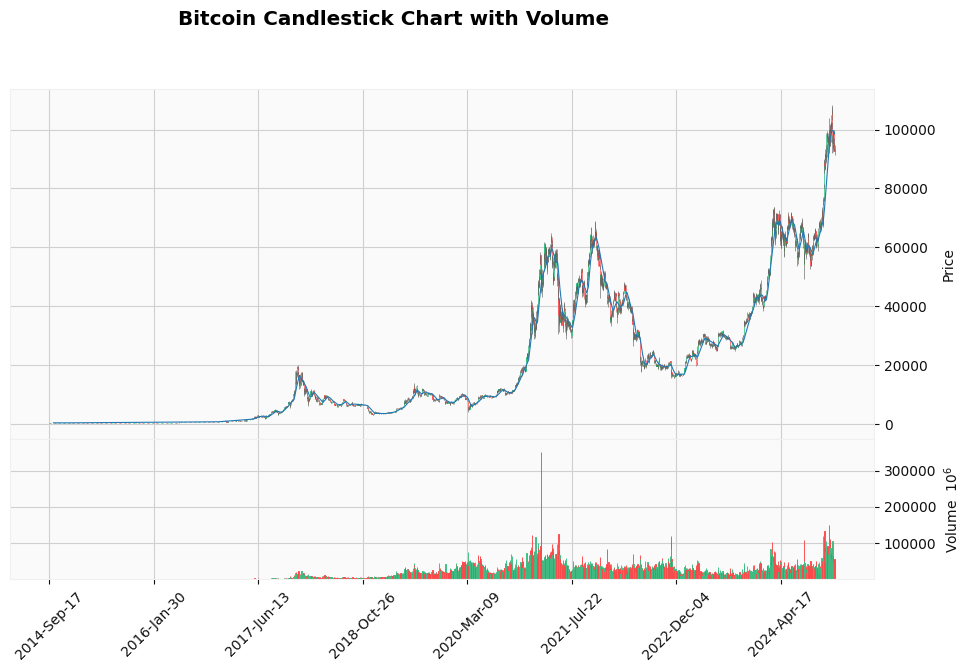

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.


/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




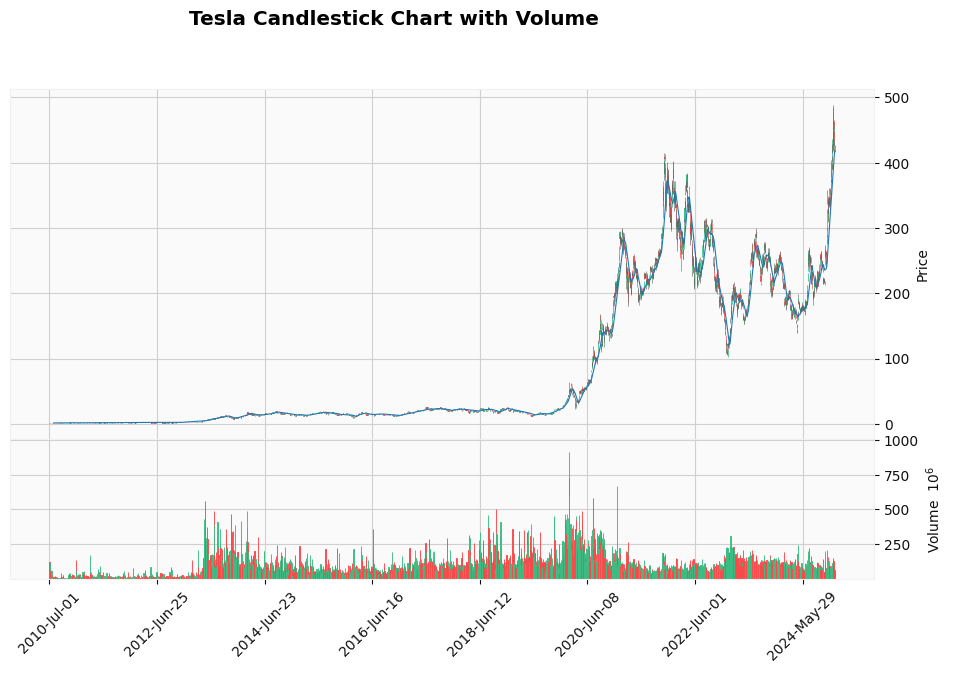

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import mplfinance as mpf
import pandas as pd
import os
from google.colab import files

# Ensure directory exists
os.makedirs("figures", exist_ok=True)

# Reformat date index
btc.index = pd.to_datetime(btc.index, dayfirst=True)
tesla.index = pd.to_datetime(tesla.index, dayfirst=True)

# Columns needed
btc_plot = btc[['Open', 'High', 'Low', 'Close', 'Volume']]
tesla_plot = tesla[['Open', 'High', 'Low', 'Close', 'Volume']]

def plot_and_download(df, name):
    # Define save path
    path = f"figures/{name}_candlestick_volume.png"

    # Plot and save PNG
    mpf.plot(df, type='candle', volume=True, style='yahoo',
             title=f"{name.capitalize()} Candlestick Chart with Volume",
             mav=(20), figsize=(12, 7), savefig=path)

    # Show the chart in notebook (separate display)
    mpf.plot(df, type='candle', volume=True, style='yahoo',
             title=f"{name.capitalize()} Candlestick Chart with Volume",
             mav=(20), figsize=(12, 7))

    # Download PNG to browser
    files.download(path)

# Run for both Bitcoin and Tesla
plot_and_download(btc_plot, "bitcoin")
plot_and_download(tesla_plot, "tesla")
